## About Me & Us

<img src="https://drive.google.com/uc?export=view&id=1BdlCq0QbQy_VKSSn1FTK7toAv6-pDyAE" width="250" />

The author of this notebook is Donatas Repečka, CTO and co-founder of the protein design company Biomatter Designs.

[Biomatter Designs](https://www.biomatterdesigns.com/) is pioneering the technology for generative Protein Design for the next-generation manufacturing and therapeutic applications. The AI-based generative approach allows to effectively construct new enzymes and therapeutic proteins with the desired functions right from the first atom.


Biomatter Designs strives to transform the protein engineering industry, which is currently dominated by slow and expensive experimental work into an industry that is driven by precise digital design of proteins for the development of novel biotherapeutics and sustainable manufacturing.

# Introduction

In this workshop I would like to demonstrate how GANs could be customized for data that is not images. In this specific case, we will use GANs to generate functional proteins. 

Prerequisites:
* Understanding of Tensorflow library
* Basic knowledge neural networks and their components
* A general understanding about how GANs work



## Generative Adversarial Networks
 
**Generative Adversarial Networks (GANs)** are powerful machine learning models capable of generating realistic examples.
 
For example, an image below is generated by implementation of GAN called [StyleGAN 2](https://arxiv.org/abs/1912.04958)
 
<img src="https://drive.google.com/uc?export=view&id=183HL6EPVXOzN1ukwKzudqdOYVsQktNlx" width=400/>
 
This is achieved by training two neural networks: discriminator and generator with opposite goals. Eventually, the generator becomes good at producing examples that are indistinguishable from true data distribution.
 
 
Naturally, this ability to generate artificial examples with high quality from random numbers is something that could be successfully employed in other fields such as protein engineering.



## Protein Engineering: Background

Proteins are large, complex molecules that play many critical roles in living organisms, including humans. You can think of them as very tiny, programmable robots used by nature to perform various functions, e.g. building, modifying or breaking down other molecules, aiding in cell replication and division, and transporting other proteins inside of cells. Apart from the crucial cellular functions, proteins are used virtually everywhere in our daily life, starting from animal nutrition and washing powders down to costly drugs and therapeutic antibodies. Using synthetic biology, protein engineering, adaptive evolutions experimental techniques, researchers enhance proteins' properties, making them more active or "sticky" towards a particular drug target or resistant to harsh environemental conditions. However, it is challenging to randomly modify proteins in a "biochemically meaningful" way such that protein would remain functional leading in a very costly time-consuming experiments. Thus generating natural-like diverse proteins that remain functional is of outstanding importance for biotechnology and biomedical applications. 


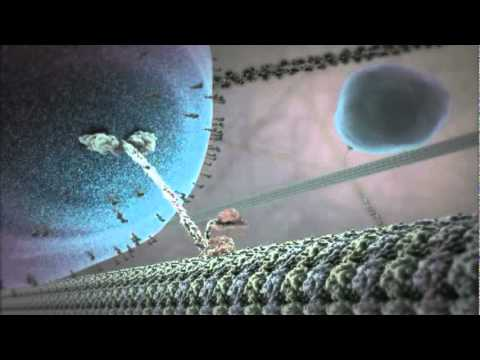

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('wJyUtbn0O5Y', start=75, end=80, autoplay=1, controls=0, loop=1, width=800, height=600)

*Above, animation of motor protein responsible for transporting objects in cells*

Source: https://www.youtube.com/watch?v=wJyUtbn0O5Y

## Generative Adversarial Network in Synthetic Biology


Proteins, like images, can be represented in various ways on the computer. Images are tensors of pixel intensities of red, green, and blue (RGB) colors which can be represented as integers from 0 to 255. Proteins, similarly, use letters to represent 20 unique amino acids, like the one below: 

> MKYATLLEYAFQALKNSYAPYSRFRVGAALLSDDGEVVTGCNVENASYGLSMCAERTAVFRAVAQGVKKFDAIAVVSGKVNPVYPCGACRQVLREFNPRLTVVVAGPGKKPLTTSLDKLLPKSFGKESLRRR

Raw pixel RGB values are easy for computers to work with, though they are not very meaningful to the human eye, which is why they are displayed as images on the screen. Similarly, the sequence of amino acids is a compact, convenient representation of the actual molecule, while the more meaningful view of the protein molecule is its 3D structure. For an example, see [Cytidine deaminase](https://www.rcsb.org/structure/1UX1).
 
For you to appreciate and reason about the outputs, you want your models (GANs) to ultimately produce meaningful structures. There are two important common features that make images and proteins both suitable candidates for GANs:

* A random combination of building blocks, whether amino acids or pixels, will not produce a realistic outcomes. This means the GAN cannot simply guess! There are meaningful, realistic patterns of pixels and amino acids that it must model and generate.
* The mathematical formula for how to evaluate the correctness of the generated item is unknown. For images, correctness is  "realism" -- how realistic does a generated image of a dog look? There's no math formula for that, so instead you have another model (the discriminator!) learn to assess that. The same goes for proteins.


On the other hand, unlike images, proteins are made out of discrete building blocks (amino acids) which is one of the main causes why GANs tailored for image generation fail to produce high quality protein sequences. A slight change of pixel values (geometric change) does not change how we recognize the image, however, a single modification in the amino acid sequence can make protein inactive. This makes the training of GANs even more challenging. 


|         | Image      | Protein  |
| ------- |:----------:| --------:|
| Data type | integers from 0 to 255 | vocab of 20 amino acids |
| Dimension| 2D | 1D|
| Number of possible variants | $3*256^{size}$ |  $20^{length}$  |

 
For more details please refer to [ProteinGAN published in Nature Machine Intelligence](https://www.nature.com/articles/s42256-021-00310-5)

In [ ]:
view = py3Dmol.view(query='pdb:1UX1')
view.setStyle({'chain':'A'}, {'cartoon':{'color':'spectrum'}})
view.addStyle({'chain':['B','C','D']},{'line':{'hidden':True}})
print("Cytidine deaminase")
view

Cytidine deaminase


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

#Toy Example: GAN for Protein Generation

We have discussed using GANs for protein synthesis, let’s try to implement this idea in practise with a simplified example.

## Setup

To begin with, let’s sort out the setup needed for us to build a toy system. 

In [ ]:
#@title Installing Dependencies
%%capture
! apt-get -qq install -y ncbi-blast+
! apt-get -qq install -y clustalo
! pip install tensorflow-addons --quiet
! pip install py3Dmol --quiet

In [ ]:
#@title Fetching Data

#/content/cdh_sequences.fasta - training data
!gdown --quiet https://drive.google.com/uc?id=1DJun7tjv8stSQVkRMc9z1rq9vZXf7l7t
#/content/db_val.phr - blastp database
!gdown --quiet https://drive.google.com/uc?id=1LGLiVf5R9zUXFQD8ux5xPiYMRlAIX8za
# /content/db_val.psq - blastp database
!gdown --quiet https://drive.google.com/uc?id=1pZkIlecl1PFThPrEnCIEDkqWTSHg9ip3
#/content/db_val.pin - blastp database
!gdown --quiet https://drive.google.com/uc?id=1txigrDFYwz1Zhqeh6_fQ96-CrwUhR2os

In [ ]:
#@title Imports
import tensorflow as tf
tf.random.set_seed(1994)
from absl import logging
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from tensorflow_probability.python.distributions import RelaxedOneHotCategorical
from IPython.display import display
import py3Dmol
import shutil

logging.set_verbosity("ERROR")
tf.get_logger().setLevel("ERROR")
np.set_printoptions(suppress=True)

In [ ]:
#@title Helper Methods

"""Dictionary to map from single letter amino acid to a arbitary id"""
AMINO_ACID_TO_ID = {'0': 0,'A': 1,'C': 2,'D': 3,'E': 4,'F': 5,'G': 6,'H': 7,
                    'I': 8,'K': 9,'L': 10,'M': 11,'N': 12,'P': 13,'Q': 14,
                    'R': 15,'S': 16,'T': 17,'V': 18,'W': 19,'Y': 20}
ID_TO_AMINO_ACID = {v: k for k, v in AMINO_ACID_TO_ID.items()}

def fasta_to_dataset(input_file):
  """
  Reads FASTA file into Tensorflow dataset. Note: this does not work with 
  sequences that are broken into multiple lines. 
  """
  df = pd.read_csv(input_file, sep="\n", lineterminator=">", index_col=False, 
                    names=["id", 'seq']) 

  def df_iterator():
    for v in df.values:
      yield [AMINO_ACID_TO_ID[c] for c in v[1].replace("\r", "")]

  dataset = tf.data.Dataset.from_generator(df_iterator, tf.int32)
  return dataset

class GANMonitor(keras.callbacks.Callback):
  """Training monitor to print generated sequences and run blast"""
  def __init__(self, num_examples=3, latent_dim=128):
    self.num_examples = num_examples
    self.latent_shape = (num_examples, latent_dim)
    self.scores = []

  def on_epoch_end(self, epoch, logs=None):
    latent_vectors = tf.random.normal(shape=self.latent_shape)
    gen_seqs = self.model.generator(latent_vectors).numpy().argmax(-1)
    fasta = ""
    print('Generated sequences:')
    for i, gen_seq in enumerate(gen_seqs):
      seq = "".join([ID_TO_AMINO_ACID[a] for a in gen_seq if a != 0])
      if len(seq) == 0:
        continue
      if i < 2:
        print(seq)
      fasta = fasta + f'>{i}\n{seq}\n'

    with open('fasta.fasta', 'w') as f:
      print(fasta, file=f)
    output = !blastp -db /content/db_val -max_target_seqs 1 -outfmt '10 qseqid score evalue pident' -evalue 0.00001 -query fasta.fasta
    output = [r.split(',') for r in output]
    print('')
    if len(output) == 0 or len(output[0]) != 4:
      print(f'At the end of epoch {epoch+1} | No significant hits were found')
      self.scores.append(0.0)
    else:
      output_df = pd.DataFrame(output, columns=['qseqid', 'score', 'evalue', 
                                                'pident'])
      output_df = output_df.set_index('qseqid')
      avg_score = output_df['score'].astype(float).sum()/self.num_examples
      print(f'At the end of epoch {epoch+1} | {len(output_df)}/{self.num_examples} hits were found with average score {avg_score}')
      self.scores.append(avg_score)
    print('')

## Reading Data

#### Cytidine Deaminase
This demonstration will use a relatively small protein called *cytidine deaminase* for simplicity. Its function in organisms is essential to DNA and RNA degradation. **Our aim is to be able to create variants of this protein that exhibit different properties.**


However, in practise we use primary structure which looks like a sequence of capital letters (see below). 

In [ ]:
"""Creating dataset from FASTA file"""
dataset = fasta_to_dataset('/content/cdh_sequences.fasta').cache()
dataset = dataset.shuffle(12000)
dataset = dataset.padded_batch(64, padded_shapes=(160))

In [ ]:
"""To print a random sequence"""
for batch in dataset:
  for seq in batch.numpy()[:8]:
    print("".join([ID_TO_AMINO_ACID[a] for a in seq if a != 0]))
  break

MLDEPLIHTLMAAARQAREAAYAPYSGDFRVGAAVLTGDGQVFTGCNVENASFGASMCAERVAIFAAVAAGQRQLTALVVIADTPQPIPPCGLCRQVLAEFAPACQVIMANTKGDYQVATMEQLLPYPFEFRQP
MNEPLRPGGEATDDGPRIDWDRLREAAVAAREHAYVPYSRFPVGAAALTEDGRVVSGCNVENASYGLTLCAECALVSALHMSGGGRLVAFVCVDGNGDVLMPCGRCRQLLHEHRAPGLRLLTVSGVRTMAEVLPDAFGPENL
MDINDLIAQSKVARENAYVPYSKFKVGAALLTEDGKVYHGCNIENSSYGLANCAERTAIFKAVSEGVKRFAAIAIVADTVGPCSPCGACRQVISEFCAPDMPVYLTNLKGDIQHTTVGELLPSAFTPEDLDNAGKHQ
MTTAPDWESLRGQARDAMSRAYAPYSRYPVGAAALVDDGRIVTGCNVENASYGLSLCAECGLISALHAGGGGRLTAFTCVDHAGDLLVPCGRCRQLLHEHGGPDLLVDTAAGIRPLSELLPDAFGAGHLKG
MSHDLFEAARAAMAKAYAPYSKFPVGAALRTEDGRVFTGANIEVASYPEGWCAETTALGHYIMGGGGKIVEIAVIAERMAKCSPCGGCRQRLAEFCQPETKLYLCDNAGVAETVTMGDMLPYGFRGDILK
MKKEKYSFEFERFESKSELAAEQKKVVEEAYDISLNAYAPYSNFNVGASVQLENGEIFSSSNQENASYPVGTCAERGLLAYVNANFPNIKIEKLAVSTPNVNYPLPPCGMCRQYILEIEKKQSQPIEIILSGKEGDVLVINSAKDLLPLHFTDEFLG
MDKQFDDLVAMALAARSKAYAPYSKFAVGAAVKCKSGAVFVGANIENRSFGLTICAERVAMGAAVAGGERDFVAIAVTSDSDEPIVPCGACRQFLAEFNPDLIIVGATVRGDRKIDSLSRLLPDPTRGILKHADPS
MKKLKIEIDYDFCQFEELSEQDQNLI

## Baseline Model 

Since data is ready, we can move on creating main components of GAN:  discriminator and generator. In this workshop, we will not focus on architectural changes of neural networks (which can be further optimised for protein generation). Hence, discriminator and generator architectures are as plain as possible. The main architectural difference compared to other online tutorials is that here 1D convolution is used instead of 2D.

In [ ]:
#@title Discriminator
def get_discriminator_block(filters, kernel_size=3, strides=1):
  conv = layers.Conv1D(filters, kernel_size=kernel_size, 
                       strides=strides, padding="valid")
  return conv, layers.LeakyReLU(alpha=0.2)

def get_discriminator():
  return keras.Sequential(
      [
      keras.layers.InputLayer(input_shape=(160, 21)),
      *get_discriminator_block(64),
      *get_discriminator_block(128, strides=2),
      *get_discriminator_block(128),
      *get_discriminator_block(256, strides=2),
      *get_discriminator_block(256),   
      layers.Flatten(),
      layers.Dropout(0.2),
      layers.Dense(1)
      ], name="discriminator")

discriminator = get_discriminator()
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 158, 64)           4096      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 158, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 78, 128)           24704     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 78, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 76, 128)           49280     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 76, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 37, 256)         

In [ ]:
#@title Generator
latent_dim = 128

def get_generator_block(filters, kernel_size=3, strides=2):
  conv_t = layers.Conv1DTranspose(filters, kernel_size=kernel_size, 
                                  strides=strides, padding="same")
  return layers.LeakyReLU(alpha=0.2), conv_t

def get_generator():
  return keras.Sequential(
      [
      keras.layers.InputLayer(input_shape=(latent_dim,)),
      layers.Dense(10*128),
      layers.Reshape((10, 128)),
      *get_generator_block(256),
      *get_generator_block(256),
      *get_generator_block(128),
      *get_generator_block(64),
      *get_generator_block(32, strides=1),
      layers.LeakyReLU(alpha=0.2),
      layers.Conv1D(21, kernel_size=1, padding="same")
      ], name="generator")

generator = get_generator()
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1280)              165120    
_________________________________________________________________
reshape (Reshape)            (None, 10, 128)           0         
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 10, 128)           0         
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 20, 256)           98560     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 20, 256)           0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 40, 256)           196864    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 40, 256)           0 

As for baseline, we will create a simplified version of Wasserstein GAN (we will skip the part where the discriminator is trained more times than the generator). For this, we will extend [Model class](https://www.tensorflow.org/api_docs/python/tf/keras/Model) from Keras API and overwrite a few methods.
 
This code is based on the examples from Keras documentation: [dcgan](https://keras.io/examples/generative/dcgan_overriding_train_step/) and [wgan_gp](https://keras.io/examples/generative/wgan_gp)


In [ ]:
#@title Baseline Model
class GAN(keras.Model):
  def __init__(self, discriminator, generator, latent_dim):
    super(GAN, self).__init__()
    self.discriminator = discriminator
    self.generator = generator
    self.latent_dim = latent_dim

  def compile(self, d_loss_fn, g_loss_fn):
    """ Initializes optimizers, metrics, etc """
    super(GAN, self).compile()
    self.d_loss_fn = d_loss_fn
    self.g_loss_fn = g_loss_fn
    self.d_optimizer = keras.optimizers.Adam(learning_rate=0.003)
    self.g_optimizer = keras.optimizers.Adam(learning_rate=0.001)
    self.d_loss_metric = keras.metrics.Mean(name="d_loss")
    self.g_loss_metric = keras.metrics.Mean(name="g_loss")
    self.step = tf.Variable(0.0)

  @property
  def metrics(self):
    return [self.d_loss_metric, self.g_loss_metric]

  def generate_seqs(self, batch_size):
    """ Using generator produces examples from random vector """
    random_latent_vectors = tf.random.normal(shape=(batch_size, 
                                                    self.latent_dim))
    generate_seqs = self.generator(random_latent_vectors)    
    return generate_seqs

  def train_discriminator(self, real_seqs_encoded, generated_seqs):
    """ Train the discriminator """
    with tf.GradientTape() as tape:             

      fake_logits = self.discriminator(generated_seqs, training=True)
      real_logits = self.discriminator(real_seqs_encoded, training=True)
      d_loss = self.d_loss_fn(d_real=real_logits, d_fake=fake_logits)
      
    grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(zip(grads, 
                                         self.discriminator.trainable_weights))
    return d_loss

  def train_generator(self, batch_size):
    """ 
    Train the generator (note that we should *not* update the weights
    of the discriminator)!
    """
    with tf.GradientTape() as tape:
      generated_seqs = self.generate_seqs(batch_size) 
      fake_logits = self.discriminator(generated_seqs, training=False)
      g_loss = self.g_loss_fn(fake_logits)
    grads = tape.gradient(g_loss, self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(zip(grads, 
                                         self.generator.trainable_weights))
    return g_loss

  def train_step(self, real_seqs):
    """ Performing a single step of the traning """
    self.step.assign_add(1.0)

    # One hot encode input
    batch_size = tf.shape(real_seqs)[0]
    real_seqs_encoded = tf.one_hot(real_seqs, 21, dtype = tf.float32)
    # Generate fake examples
    generated_seqs = self.generate_seqs(batch_size)        

    # Optimize discriminator
    d_loss = self.train_discriminator(real_seqs_encoded, generated_seqs)
    # Optimize generator
    g_loss = self.train_generator(batch_size)       

    # Update metrics
    self.d_loss_metric.update_state(d_loss)
    self.g_loss_metric.update_state(g_loss)
    return {
        "d_loss": self.d_loss_metric.result(),
        "g_loss": self.g_loss_metric.result(),
    }


In [ ]:
#@title WGAN Loss 
#source: https://keras.io/examples/generative/wgan_gp/ 
def discriminator_loss(d_real, d_fake):
    real_loss = tf.reduce_mean(d_real)
    fake_loss = tf.reduce_mean(d_fake)
    return fake_loss - real_loss

def generator_loss(d_fake):
    return -tf.reduce_mean(d_fake)

Baseline model will be run for 25 epochs (notice that the dataset is repeated 5 times, hence 5*5=25) and we will use BLAST to evaluate generated sequences. While this tool is not perfect, it gives an indication whether sequences are similar to natural ones (for this we will use a validation dataset where sequences are at most 70% similar to the ones used for training). What we are looking for is for BLAST to find some matches with high scores. Just keep in mind, the generator never saw training, not to mention validation sequences.


In [ ]:
def train(gan, epochs = 5):
  callbacks = [GANMonitor(num_examples=10, latent_dim=latent_dim)]
  # Dataset is repeated 5 times just to make it easier to see the process
  gan.fit(dataset.prefetch(10).repeat(5), epochs=epochs, callbacks=callbacks)

In [ ]:
#@title Training the Baseline Model
gan = GAN(discriminator=get_discriminator(), 
          generator=get_generator(), 
          latent_dim=latent_dim)
gan.compile(d_loss_fn=discriminator_loss, g_loss_fn=generator_loss)
train(gan)

Epoch 1/5
845/845 [==============================] - 72s 47ms/step - d_loss: -79020580864.0000 - g_loss: 132101390336.0000
Generated sequences:
HHHHMHVHVHVHMHVHMHVHMHVHVHVHMHVHVHVHVHVHVHVHMHVHVHHHMHVHMHVHMHVHVHVHMHVHVHVHMHVHVHVHMHVHVHVHMHVHVHVHMHVHVHVHMHVHMHMHMHVHMHMHMHMHVHMHMHVHVHVHMHVHVHHHMHVHMHVHMHVH
HPHPSHHHHHVHVHVHVHVHMHVHVHVHMHAHMHMMMHMHMHMHMHMHVHMHMHVHMHMHMHVHVHMHMHVHMHMHMHMHMHMHMHVHMHMHMHVHVHMHMHVHMHVHMHVHMHMHMHVHMHMHMHMHMHMHMHMHMHMHMHMHMHMHMHMHMHMHMHMH

At the end of epoch 1 | No significant hits were found

Epoch 2/5
845/845 [==============================] - 38s 45ms/step - d_loss: 306918272.0000 - g_loss: 244100400.0000
Generated sequences:
PPSPPPPPPPVPPPPHPPVPNPVHNPVPNPVHPPVPNPVPNPVPNPVHPPVPNPVPNPVPPPVHPPVPNPVPNPVPNPPHPPVPNPVPNPVPNPVHNPVPNPVPNPVHPPVHPPMPNPVHNPVPNPVHNPVPNPVPNPMHPPVHPPMHPPVPNPMHPPVH
PPPPPPVPPPMPPPVHPPMHPPAHPPMHMPSHSPMPPPMPPPMHMPMHPPMHMPAHPPMHMPAHSPMMMPAHPPAMMPSPCPMPPPVPNPMHPPMHPPMHPPMHPPVHPHMHPPMHPPVHPPVHNPVHPPMHPPMHPPMHMHMHPPMHMHMHPFMHMHMH

At the end of ep

This does not look great. Sequences are not looking anything like the ones from the dataset and no hits are found by BLAST.

## Non-saturating Loss with R1 regularization

The first thing that draws attention is that losses are exploding. To mitigate this, we can implement non-saturating loss that will prevent loss from going out of control. This can be achieved by applying softplus operation on discriminator scores (note this has been proposed by Ian Goodfellow in original [Generative Adversarial Networks paper](https://arxiv.org/abs/1406.2661)):

$$ f(x) = log(1 + exp(x))$$

In [ ]:
#@title Non-saturating Loss
def discriminator_loss_non_saturating(d_real, d_fake):
    d_loss_real = tf.reduce_mean(tf.nn.softplus(-d_real))
    d_loss_fake = tf.reduce_mean(tf.nn.softplus(d_fake))
    d_loss = d_loss_real + d_loss_fake
    return d_loss

def generator_loss_non_saturating(d_fake):
    return tf.reduce_mean(tf.nn.softplus(-d_fake))

In [ ]:
gan = GAN(discriminator=get_discriminator(), 
          generator=get_generator(), 
          latent_dim=latent_dim)
gan.compile(d_loss_fn=discriminator_loss_non_saturating, 
            g_loss_fn=generator_loss_non_saturating)
train(gan)

Epoch 1/5
845/845 [==============================] - 39s 44ms/step - d_loss: 131.1320 - g_loss: 1098.5549
Generated sequences:
PIEIAIEIACECAIETECECECVRECECECEGEGEGEGEGEGEGEAEGEGECECDCECECECECECECECEAQCEIAIECEGEGEGADQAAIAIECEGEGEGADAAPAPIAACECACDRECEIAIEIEIEIAIAIAIAIAIPIARPRPPRQPIRRAIER
AIEIAIEIACECAIERACECECVCECECECVGEGEGEGEGEGEGEGECECECECVCECECECVCECECECDRECEIEIVCEGEGEGIDIAPAIAGEGEGEGIGIIPIPIPACECLCDCECECAIEIARECAIQIAIAIAIAPPPQQQAIQAIAIAIPQ

At the end of epoch 1 | No significant hits were found

Epoch 2/5
845/845 [==============================] - 37s 44ms/step - d_loss: 19.8070 - g_loss: 381.3252
Generated sequences:
VENLETISWPAAEEISIPILETISWPAECEWSRLWECVYGCGEECEYGCGEECEWECGCECEWSCFCAEIISIPCAEEISCPCAEEISCPCAEIIECPCAEELNECECEAELELFEPCWCIISVPVDEFNVW
VNNLETISWPAAEEISPPLEIISWPECVWSCLWECVCGCGEECEEGCGEECEWECGCECEWSCFEAETISCPAAEIIECPCAEELTCPAAEAIECCLEIFTCCCEAEEELFEPCWCIIEEEEFEVPWPR

At the end of epoch 2 | No significant hits were found

Epoch 3/5
845/845 [==============================] -

While this helps to constrain the loss, there are no observable improvements in terms of quality of generated sequences. Fortunately, based on [Mescheder paper](https://arxiv.org/abs/1801.04406) we know that gradient penalties improve the convergence. R1 - refers to penalties of discriminator gradients on true data distribution:
 
$$R_1(\psi) = \frac{\gamma} 2 \mathbf{E}_{pD}(x)[||\nabla D_\psi(x)||^2]$$
 
 
 
In code we can implement this using [GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape) and watching input tensor.


In [ ]:
#@title R1 Regularization 
class GANLossR1(GAN):
  def train_discriminator(self, real_seqs_encoded, generated_seqs):
    # Train the discriminator
    with tf.GradientTape() as tape , tf.GradientTape() as r1_penalty_tape:
      r1_penalty_tape.watch(real_seqs_encoded)              

      fake_logits = self.discriminator(generated_seqs, training=True)
      real_logits = self.discriminator(real_seqs_encoded, training=True)
      d_loss = self.d_loss_fn(d_real=real_logits, d_fake=fake_logits)

      real_grads = r1_penalty_tape.gradient(tf.reduce_sum(real_logits), 
                                            [real_seqs_encoded])[0]
      r1 = tf.reduce_sum(tf.square(real_grads), axis=[1, 2])

      d_loss +=  r1 * 5.0 # a hyperparameter which can be tuned 

    grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(zip(grads, 
                                         self.discriminator.trainable_weights))
    return d_loss

In [ ]:
gan = GANLossR1(discriminator=get_discriminator(), 
                generator=get_generator(), 
                latent_dim=latent_dim)
gan.compile(d_loss_fn=discriminator_loss_non_saturating, 
            g_loss_fn=generator_loss_non_saturating)
train(gan)

Epoch 1/5
845/845 [==============================] - 50s 56ms/step - d_loss: 1.0985 - g_loss: 1.3651
Generated sequences:
AGAIGAYAGLIGTAAFRLPCREELLKGVSSKAEEGTENALVIGAEIALVIGAEVAGAIGASVAGVIGAVAGAIGTAAALSELRGLAYEGLRGILDEGNAEVAGVIGAEVAGVIPVPIAPAYAKAALDAGARGGA
AAGAVGIPGAGAAGAAGAGAAEGTLDEGAEGTRDAGVLSGVAGTVLEPRSPLRGNALAGNAERALVIGAVAGAIGVAAALARYSPNAGAVLSKSAGAAGATGAGAVLTKGAGAVLTTEAGGVLSKKAGAVLRPQAGAVLRY

At the end of epoch 1 | No significant hits were found

Epoch 2/5
845/845 [==============================] - 47s 56ms/step - d_loss: 1.1754 - g_loss: 1.0620
Generated sequences:
MKYPENEACVGANAASADGKGRRVKGVPYSKYIPSAFYVPNFAPVQVILSEANAKAAAISVNVEMKYIDNVGIVGNRNSVTNVAIDGNAAAVPDVNKAVDVLITVVGIRNRVVTVPPTGYAANAIAEAADFTGGDSGGVVGGG
MKETGKEDGGVIVKDGALTKRNVAGLGKVVVSVDGNENRATVAAFAIKPTVTGADDCGVIVAEKALFTLKEGAIFIVVVGGVVVGGSNIVNVVTNPPAEAAAFSVKVNVIVVVKIPVIVLVAIKVDVKGKAAGEGKTKAANA

At the end of epoch 2 | No significant hits were found

Epoch 3/5
845/845 [==============================] - 47s 56ms/step - d_loss: 1

## Categorical Reparameterization Trick 

This time it looks better and we even (not always) get some hits from BLAST. Although we ignore the fact that our input is one-hot encoded. If we produce sequences using the generator and then perform argmax operation (which is not differentiable, unfortunately), we see that the discriminator scores (the higher, the better) differ. That indicates that the discriminator leverages the fact that generated sequences are not completely one-hot encoded. 

In [ ]:
gen_seqs = gan.generate_seqs(16)
gen_seqs[:2, 45].numpy()

array([[ 0.47555086,  0.04263934,  0.2675383 , -0.12096094, -0.2100828 ,
         0.03005927, -0.02424216, -0.267574  ,  0.05772799, -0.00337951,
         0.3713896 , -0.04744346, -0.1166904 ,  0.02174968, -0.41567218,
         0.5371393 ,  0.56006175,  0.15161656, -0.07408412, -0.04621504,
         0.06380918],
       [ 0.59507877, -0.17969336,  0.01274711, -0.02815276,  0.07634322,
        -0.02219142, -0.08892188,  0.2606557 , -0.1362936 , -0.03028421,
         0.29796565, -0.20806435, -0.14027461, -0.02924195, -0.14338237,
        -0.01997772,  0.0839853 ,  0.10726281,  0.2792397 , -0.02175916,
        -0.00970733]], dtype=float32)

In [ ]:
gan.discriminator(gen_seqs).numpy().sum()

-24.385616

In [ ]:
one_hot_encoded_gen = tf.one_hot(tf.math.argmax(gen_seqs, axis=-1), 21)
gan.discriminator(one_hot_encoded_gen).numpy().sum()

-10.1049

Ideally, we want the generator to produce one-hot encoded sequences straight away so that the discriminator could not use this to distinguish generated from real. To achieve this, we will use [RelaxedOneHotCategorical](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/RelaxedOneHotCategorical) to approximate 21-class one-hot categorical distribution while allowing us optimise the model end-to-end.

To read more about this: [Gumbel-Softmax (Jang et al., 2016)](https://arxiv.org/abs/1611.01144) and [Concrete (Maddison et al., 2016)](https://arxiv.org/abs/1611.00712)

An example:

In [ ]:
logits = [0.85, 0.1, 0.05]
RelaxedOneHotCategorical(temperature=0.0001, logits=logits).sample().numpy()

array([1., 0., 0.], dtype=float32)

The implementation is quite simple. The only hyperparameter is temperature which should decrease as training progresses. 

In [ ]:
#@title Implementation of One Hot approximation
class GANLossR1Relaxed(GANLossR1):
  """ Using generator produces examples from random vector """
  def generate_seqs(self, batch_size):
    random_latent_vectors = tf.random.normal(shape=(batch_size, 
                                                    self.latent_dim))
    generate_seqs = self.generator(random_latent_vectors)    
    temperature = 1 / tf.math.log(self.step)
    generate_seqs = RelaxedOneHotCategorical(temperature=temperature,
                                            logits=generate_seqs).sample()
    return generate_seqs

In [ ]:
#@title Training Final Version 
gan = GANLossR1Relaxed(discriminator=get_discriminator(), 
                       generator=get_generator(), 
                       latent_dim=latent_dim)
gan.compile(d_loss_fn=discriminator_loss_non_saturating, 
            g_loss_fn=generator_loss_non_saturating)
train(gan)

Epoch 1/5
845/845 [==============================] - 51s 56ms/step - d_loss: 1.2360 - g_loss: 0.9207
Generated sequences:
MKKEEEEEEEEARREEEAERRRKRAAAAAVAAAGGGAGGAAAAAAAAAAGGGGGGAAAGAAAGAAAEEEEEEEAAAAAAACGGGGGGGCCCCCCGCPEEEEEEEEPEPPPPEEEEEEEEEEPEPPPEEEPG
MTEEEEEEEEEAPEEEEEGAAAEAMEEEGVGGCCGCCCCGGAAAAAAAAAAANGGFNVGAAAAAAAAAAAVEAVGAAAVGEGGGGGGGGGPPPPGGGPEEPPEPPPPPGGGGCGGAAAAAAAAEGVGAAAAAAAEEAAGAAAAAMKK

At the end of epoch 1 | 1/10 hits were found with average score 9.0

Epoch 2/5
845/845 [==============================] - 48s 57ms/step - d_loss: 1.2658 - g_loss: 0.8422
Generated sequences:
MTDDELIEEAAEAAAAEAAKAKVALAYAGRAESAFRVGRVVTNENASYGLTNCAERTAIIAAIAMSDREFQELAYASDTEAYAPYPIPPCGACRQVALLDDGIVVTGLAFGFPELTVKELLPYAFTKK
MTKAARAAARAAARAAAAYYYRFYSKFHVGAAATYSANNAASNNNNNAAYYNANNAARAAARAAAAYASRPYSHFIVGAAAAAAALAAAEAAAAIAASDDPDLPVINSDGRQKELTEIFAEGDNAKEELAYAFG

At the end of epoch 2 | 10/10 hits were found with average score 189.7

Epoch 3/5
845/845 [==============================] - 48s 57ms/step - 

Nice! This time, we got some matches with high identity. This is a good indication that the GAN works well in generating realistic protein sequences. Even generated sequences now look much more like being one hot encoded (the discriminator scores are much closer). 


In [ ]:
gen_seqs2 = gan.generate_seqs(2)
gen_seqs2[:, 45].numpy()

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0.]], dtype=float32)

In [ ]:
gan.discriminator(gen_seqs2).numpy().sum()

-0.41770518

In [ ]:
one_hot_encoded_gen = tf.one_hot(tf.math.argmax(gen_seqs2, axis=-1), 21)
gan.discriminator(one_hot_encoded_gen).numpy().sum()

-0.41672885

## Structure of Generated Sequence

With the incredible breakthrough of [AlphaFold2](https://www.nature.com/articles/s41586-021-03819-2), now we have an ability to accurately predict structures from amino acid sequences. I took one of generated sequences by our simplified GAN:
> MTLDELIDAAIEARERAYVPYSGFKVGAALLTKDGTIYTGCNVENAAYPYGLCACAEVSAMCSASGHSEIKVLVVVGDTERPGSPCGACRQVMAEFYELGEALIIAITWNPIDLTTVSELLPHSFNGELLPK

And then used AlphaFold2 to predict the structure. The image below shows aligned structures of generated sequence (green) and cyan (determined experimentally: PDB ID: [1ux1](https://www.rcsb.org/structure/1UX1)). Bear in mind that sequences are not identical. In fact they are only 46.4% similar (have identical amino acids). 

<img src="https://drive.google.com/uc?export=view&id=1_3c0sOC27oDiL9dsU0lTmZgSTSNPke42" />

That is incredible: being able to come up with a unique sequence of amino acids that folding in the same structure is a small, but significant step towards understanding the *protein language*. Furthermore, this allows us to search for interesting proteins with unique or improved properties (for example,stability or expresability) without impairing the function. 

## Concluding Remarks

In summary, this has been a demonstration of how GANs can be extended/modified to work well when inputs are discrete. I hope this workshop serves as a good starting point for everyone who wants to use GANs to produce high quality examples which are not necessarily images. 
